In [2]:
import os
os.environ["TORCH_USE_CUDA_DSA"] = "1"
os.environ["CUDA_LAUNCH_BLOCKING"]="1"
import cv2
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from torchvision.models import inception_v3
from scipy.stats import entropy
from scipy.linalg import sqrtm
from torch.optim import AdamW
from diffusers import UNet2DModel, DDPMScheduler, DDPMPipeline
from diffusers.optimization import get_cosine_schedule_with_warmup
from datasets import load_dataset
from accelerate import Accelerator
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import random 
import timeit
from numpy import cov


In [3]:
RANDOM_SEED = 42
IMG_SIZE = 128
BATCH_SIZE = 2
LEARNING_RATE = 1e-4
NUM_EPOCHS = 20
NUM_GENERATE_IMAGES = 9
NUM_TIMESTEPS = 1000
MIXED_PRECISION = "fp16"
GRADIENT_ACCUMULATION_STEPS = 1

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"


In [5]:
class NpyDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.file_list = os.listdir(root_dir)
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_name = self.file_list[idx]
        file_path = os.path.join(self.root_dir, file_name)
        image = np.load(file_path)
        if len(image.shape) == 2:
            image = cv2.resize(image, (128, 128))
        elif len(image.shape) == 3:
            image = np.transpose(image, (1, 2, 0))
            image = cv2.resize(image, (128, 128))
        image=np.array(image)
        image=np.float32(image)
        image=Image.fromarray(image)
        if self.transform:
            image = self.transform(image)
        return image

In [11]:
preprocess = transforms.Compose(
[
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

train_dataset = NpyDataset('Samples', transform=preprocess)

In [12]:
i=train_dataset[1]
i.shape

torch.Size([1, 128, 128])

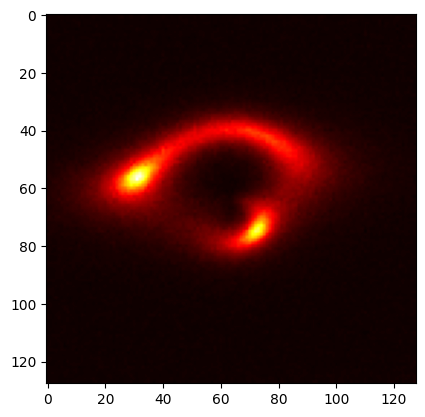

In [13]:
i=i.permute(1,2,0)
i=i.cpu().detach().numpy()
plt.imshow(i, cmap='hot')

In [14]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [15]:
model = UNet2DModel(
    sample_size=IMG_SIZE,
    in_channels=1,
    out_channels=1,
    layers_per_block=2,
    block_out_channels=(128, 128, 256, 256, 512, 512),
    down_block_types=(
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",
        "DownBlock2D"
    ),
    up_block_types=(
        "UpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D"
    )
)
model = model.to(device)

In [16]:
sample_image = train_dataset[0].unsqueeze(0).to(device)
print("Input shape", sample_image.shape)
print("Output shape", model(sample_image, timestep=0).sample.shape)

Input shape torch.Size([1, 1, 128, 128])
Output shape torch.Size([1, 1, 128, 128])


In [17]:
noise_scheduler = DDPMScheduler(num_train_timesteps=NUM_TIMESTEPS)
noise = torch.randn(sample_image.shape).to(device)
timesteps = torch.LongTensor([50]).to(device)
noisy_image = noise_scheduler.add_noise(sample_image, noise, timesteps)

In [18]:
noise_pred = model(noisy_image, timesteps).sample
loss = F.mse_loss(noise_pred, noise)
print(loss)

tensor(1.0872, device='cuda:0', grad_fn=<MseLossBackward0>)


In [19]:
def sample_image_generation(model, noise_scheduler, num_generate_images, random_seed, num_timesteps):
    pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)
    
    images = pipeline(
        batch_size=num_generate_images,
        generator=torch.manual_seed(random_seed),
        num_inference_steps=num_timesteps
    ).images
    
    fig = plt.figure()
    for i in range(1, num_generate_images+1):
        fig.add_subplot(3, 3, i)
        plt.imshow(images[i-1], cmap='hot')
    plt.show()
    return images

In [20]:
device

'cuda'

100%|███████████████████████████████████████| 5000/5000 [34:12<00:00,  2.44it/s]

------------------------------
Train Loss EPOCH: 1: 0.0113
Train Learning Rate EPOCH: 1: 9.949638903496335e-05


  0%|          | 0/1000 [00:00<?, ?it/s]

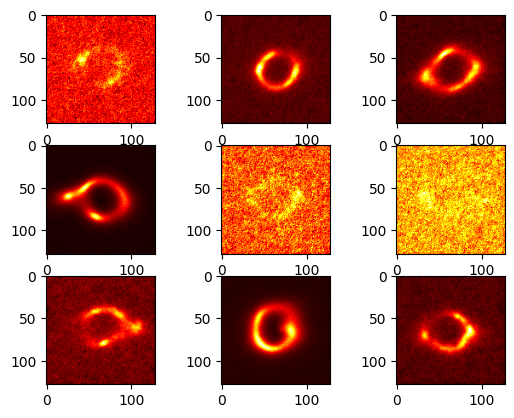

  5%|█▉                                     | 1/20 [39:36<12:32:27, 2376.20s/it]

------------------------------


 10%|███▋                                 | 2/20 [1:12:32<10:42:13, 2140.73s/it]

------------------------------
Train Loss EPOCH: 2: 0.0036
Train Learning Rate EPOCH: 2: 9.77684804023476e-05
------------------------------


 10%|███▋                                 | 2/20 [1:13:28<11:01:18, 2204.34s/it]


KeyboardInterrupt: 

In [21]:
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)

lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=500,
    num_training_steps=len(train_dataloader)*NUM_EPOCHS
)

accelerator = Accelerator(
    mixed_precision=MIXED_PRECISION,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS
)

model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(model, optimizer, train_dataloader, lr_scheduler)

start = timeit.default_timer()
for epoch in tqdm(range(NUM_EPOCHS), position=0, leave=True):
    model.train()
    train_running_loss = 0
    for idx, batch in enumerate(tqdm(train_dataloader, position=0, leave=True)):
        clean_images = batch.to(device)
        noise = torch.randn(clean_images.shape).to(device)
        last_batch_size = len(clean_images)
        
        timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (last_batch_size,)).to(device)
        noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)
        
        with accelerator.accumulate(model):
            noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
            loss = F.mse_loss(noise_pred, noise)
            accelerator.backward(loss)
            
            accelerator.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            
        train_running_loss += loss.item()
    train_loss = train_running_loss / (idx+1)
    
    train_learning_rate = lr_scheduler.get_last_lr()[0]
    print("-"*30)
    print(f"Train Loss EPOCH: {epoch+1}: {train_loss:.4f}")
    print(f"Train Learning Rate EPOCH: {epoch+1}: {train_learning_rate}")
    if epoch%10 == 0:
        sample_image_generation(model, noise_scheduler, NUM_GENERATE_IMAGES, RANDOM_SEED, NUM_TIMESTEPS)
    print("-"*30)
    
stop = timeit.default_timer()
print(f"Training Time: {stop-start:.2f}s")

  0%|          | 0/1000 [00:00<?, ?it/s]

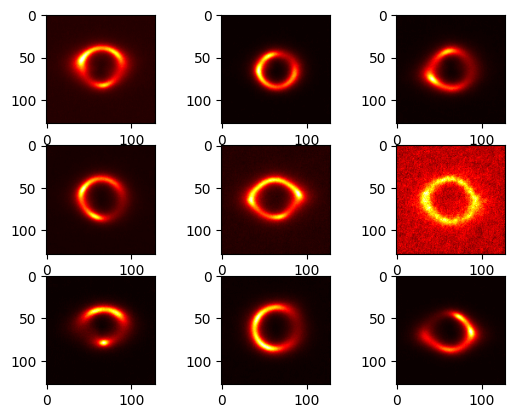

In [22]:
i=sample_image_generation(model, noise_scheduler, NUM_GENERATE_IMAGES, RANDOM_SEED, NUM_TIMESTEPS)

In [23]:
torch.save(model.state_dict(), 'ddpm_weights.pth')

In [24]:
generated_imgs=[]
actual_imgs=[]

In [25]:
for el in i:
    im=np.array(el)
    # im=torch.tensor(im, device=device)
    # im=im.unsqueeze(0)
    # im=im.cpu().detach().numpy()
    generated_imgs.append(im)

In [26]:
indices=np.random.choice(len(train_dataset), size=NUM_GENERATE_IMAGES, replace=False).tolist()

In [27]:
for ind in indices:
    im=train_dataset[ind]
    # im=im.permute(0,1,2)
    # im=im.cpu().detach().numpy()
    im=im.reshape(128,128)
    im=im.cpu().detach().numpy()
    actual_imgs.append(im)

In [28]:
generated_imgs[0].shape

(128, 128)

In [29]:
actual_imgs[0].shape

(128, 128)

In [30]:
act_dir='Actual/'
gen_dir='Generated/'

In [31]:
for i in range(len(actual_imgs)):
    img_uint8=(actual_imgs[i] * 255).astype(np.uint8)
    im=Image.fromarray(img_uint8)
    name=os.path.join(act_dir, f'act{i}.jpg')
    im.save(name)

In [33]:
for i in range(len(generated_imgs)):
    img_uint8=(generated_imgs[i] * 255).astype(np.uint8)
    img_uint8=255-img_uint8
    im=Image.fromarray(img_uint8)
    name=os.path.join(gen_dir, f'gen{i}.jpg')
    im.save(name)

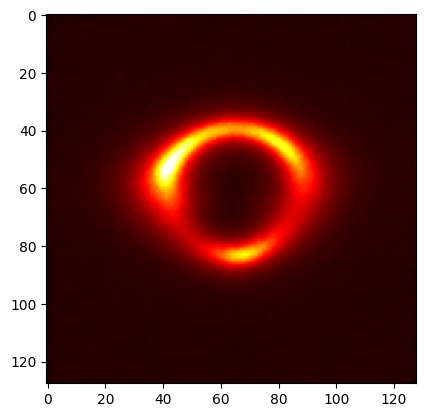

In [34]:
plt.imshow(generated_imgs[0], cmap='hot')

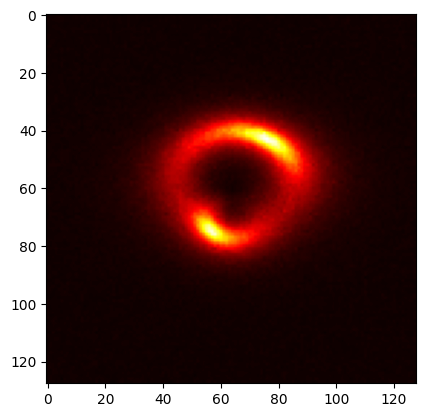

In [35]:
plt.imshow(actual_imgs[0], cmap='hot')